## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy.linalg import multi_dot
from sklearn.metrics.pairwise import rbf_kernel

# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Question 1: Bias Variance Decomposition

The function
toydata.py generates a binary data set with class 1 and 2. Both are sampled from Gaussian distributions:
p(x|y = 1) ∼ N (0, I) and p(~x|y = 2) ∼ N (µ2, I), (1)
where µ2 = [2; 2]> (the global variable OFFSET = 2 regulates these values: µ2 = [OFFSET ; OFFSET]>).


In [2]:
# Function to generate data
def toydata(n,mu1,sigma1,offset):
  dist1 = np.random.normal(mu1, sigma1, size=((int(np.ceil(n/2))),2))
  dist1 = pd.DataFrame(dist1, columns=['x','y'])
  dist1['class'] = 1
  mu2 = mu1 + offset
  sigma2 = sigma1
  dist2 = np.random.normal(mu2, sigma2,  size=((int(np.ceil(n/2))),2))
  dist2 = pd.DataFrame(dist2, columns=['x','y'])
  dist2['class'] = 2
  final_dist = pd.concat([dist1,dist2])
  final_dist.reset_index(inplace = True, drop = True)
  final_dist = shuffle(final_dist)
  final_dist.reset_index(inplace = True, drop = True)
  X = final_dist[['x','y']].to_numpy()
  y = final_dist['class'].to_numpy()  
  return X,y  

In [3]:
# Creating 2 Gaussian distributions and the final dataset
n = 1000
mu1 = 0
sigma1 = 1
offset = 2
X,y = toydata(n,mu1,sigma1,offset)

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Plot of data')

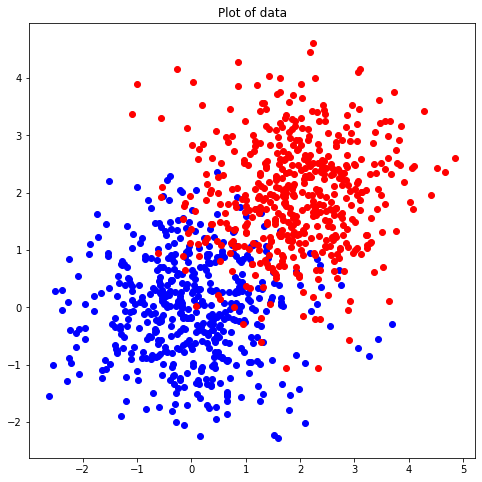

In [4]:
# plotting data
i1 = y == 1
i2 = y == 2
plt.figure(figsize=(8,8))
plt.scatter(X[i1, 0], X[i1, 1], c='b')
plt.scatter(X[i2, 0], X[i2, 1], c='r')
plt.title("Plot of data")
plt.show()

### (a) Noise (computeybar)

In [5]:
# Function to calculate y bar
def computeybar(n,X,offset):
  ybar = np.zeros(n)
  normpdf = lambda x, mu, sigma: np.exp(-0.5*np.power((x - mu)/sigma,2)) / (np.sqrt(2*np.pi)* sigma)
  for i in range(n):
    dist1_prob = np.prod(normpdf(X[i],0,1))*0.5
    dist2_prob = np.prod(normpdf(X[i],offset,1))*0.5
    dist1_prob1 = dist1_prob/(dist1_prob+dist2_prob)
    dist2_prob1 = dist2_prob/(dist1_prob+dist2_prob)
    ybar[i]=1*dist1_prob1 + 2*dist2_prob1
  return ybar

### (b) Bias (computehbar)

In [6]:
# Function to calculate distance
def dist(X, Z=None):
  n, d = X.shape
  m, _ = Z.shape
  s1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
  s2 = np.sum(np.power(Z, 2), axis=1).reshape(1,-1)
  D1 = -2 * np.dot(X, Z.T) + repmat(s1, 1, m)
  D = D1 + repmat(s2, n, 1)
  D = np.sqrt(np.maximum(D, 0))
  return D

In [7]:
# Function for kernalized ridge
def kRidge(X_train,y_train,sigma,lbda):
    kernel = lambda x, y: np.power(1+(np.power(dist(x,y),2) / (2 * np.power(sigma,2))),-4)
    ridge = lambda K, lbda: K + lbda * np.eye(K.shape[0], K.shape[1])
    beta = np.linalg.solve(ridge(kernel(X_train, X_train), lbda), y_train)
    reg = lambda Xt: np.dot(kernel(Xt, X_train), beta)
    return reg

In [8]:
# Function to calculated computehbar
def computehbar(n,n_models,n_small,mu1,sigma1,offset,sigma,lbda,X_test):
  hbar = np.zeros(n)
  for l in range(n_models):
    X_train, y_train = toydata(n_small,mu1,sigma1,offset)
    kreg = kRidge(X_train,y_train,sigma,lbda)
    y_pred = kreg(X_test)
    hbar += y_pred
  hbar = hbar/n_models
  return hbar

### (c) Variance (computevariance.py)

In [9]:
# Function to calculate variance
def computevariance(n_models,n_small,mu1,sigma1,offset,sigma,lbda,X_test,hbar):
  var = np.zeros(n)
  for i in range(n_models):
    X_train, y_train = toydata(n_small,mu1,sigma1,offset)
    kreg = kRidge(X_train,y_train,sigma,lbda)
    y_pred = kreg(X_test)
    var1 = (y_pred - hbar)**2
    var += var1
  variance = np.mean(var)/n_models
  return variance

### (d) Demo (biasvariancedemo)

In [10]:
n_models = 25
n_small = 10
lambda_vals = np.arange(-7, 0, 0.5)
lambda_len = len(lambda_vals)
sigma = 3
variance_vals = np.zeros(lambda_len)
bias_vals = np.zeros(lambda_len)
noise_vals = np.zeros(lambda_len)
error_calc = np.zeros(lambda_len)
error_act = np.zeros(lambda_len)

for i in range(lambda_len):
  # Generating test data
  X_test, y_test = toydata(n,mu1,sigma1,offset)
  
  mse = 0
  # Calculating error from model fit
  for j in range(n_models):
    X_train, y_train = toydata(n_small,mu1,sigma1,offset)
    kreg = kRidge(X_train,y_train,sigma,2**lambda_vals[i])
    y_pred = kreg(X_test)
    mse += np.mean((y_pred - y_test) ** 2)
  mse = mse/n_models 

  # Calculating ybar
  ybar = computeybar(n,X_test,offset)
  noise = np.mean((y_test-ybar) ** 2)

  # Calculating hbar
  hbar = computehbar(n,n_models,n_small,mu1,sigma1,offset,sigma,2**lambda_vals[i],X_test)
  bias = np.mean((hbar-ybar) ** 2)
    
  # Calculating variance
  variance = computevariance(n_models,n_small,mu1,sigma1,offset,sigma,2**lambda_vals[i],X_test,hbar)

  variance_vals[i] = variance
  bias_vals[i] = bias
  noise_vals[i] = noise
  # Calculating error from bias, variance and noise
  error_calc[i] = bias_vals[i]+variance_vals[i]+noise_vals[i]
  error_act[i] = mse

### Plot

<Figure size 864x648 with 0 Axes>

Text(0.5, 1.0, 'Actual error vs Calculated error')

Text(0.5, 0, 'Regularization lambda')

Text(0, 0.5, 'Squared Error')

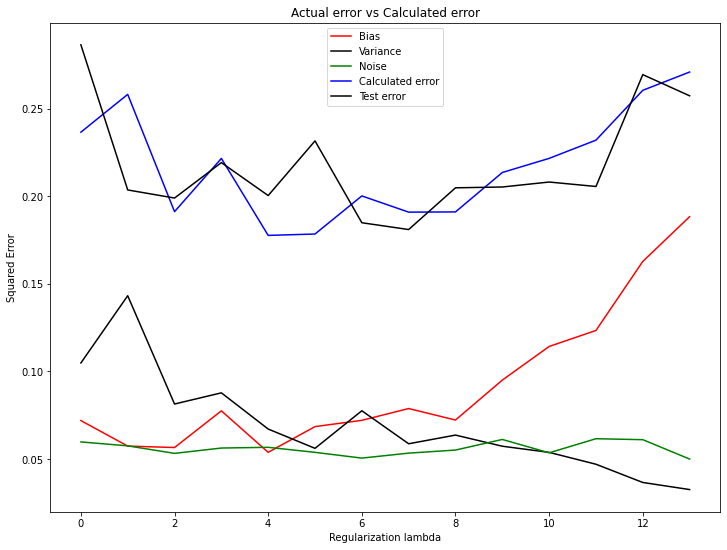

In [11]:
# Plotting bias, variance, noise, calculated error and actual error
plt.figure(figsize=(12,9))
plt.plot(bias_vals[:lambda_len],c='r')
plt.plot(variance_vals[:lambda_len],c='k')
plt.plot(noise_vals[:lambda_len],c='g')
plt.plot(error_calc[:lambda_len],c='b')
plt.plot(error_act[:lambda_len],c='k')
plt.title("Actual error vs Calculated error")
plt.legend(["Bias","Variance","Noise","Calculated error","Test error"])
plt.xlabel("Regularization lambda")
plt.ylabel("Squared Error")